In [1]:
import numpy as np
from simplelandscape import (
    flat_energy, linear_energy, logistic_energy, quadratic_energy,
    umbrella_bias, OneDimLandscape)
from remd import RemdLadder, RemdLadderJensen
import adapt
from matplotlib import pyplot as pp
%matplotlib inline
%load_ext line_profiler

In [2]:
n_cond = 12
bias_x = np.linspace(400, 600, n_cond, dtype=int)
bias_x[0] = 400

walkers = []
for x in bias_x:
    p = np.array((x, 0.015))
    w = OneDimLandscape(logistic_energy, umbrella_bias, x, p)
    walkers.append(w)

r = RemdLadderJensen(walkers)

In [3]:
n_steps = 2000
coords = np.zeros((n_steps, n_cond))
for i in range(n_steps):
    r.update()
    x = np.array([w.x for w in r.walkers])
    coords[i, :] = x

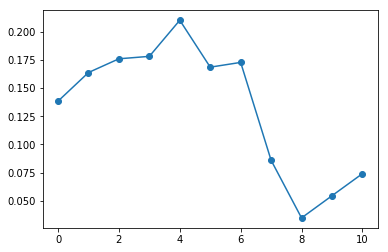

In [4]:
acc1 = r.acceptance.copy()
a1 = np.product(acc1)
pp.plot(acc1, marker='o')
#pp.ylim(0, 1)


In [5]:
lr = adapt.LearningRateDecay(np.array((1, 1e-8)), 1e-2)
param_bounds = np.array([[0, 0*0.01], [1000, 0.015]])
m = adapt.MomentumSGD(0.9, adapt.compute_derivative_jensen,
                      lr, param_bounds)
#lr = adapt.LearningRateDecay(np.array((1, 1e-4)), 0)
#m = adapt.Adam(0.9, 0.999, adapt.compute_derivative_jensen, lr)
a = adapt.Adaptor(r, 8, m)

In [6]:
a.run(5000)

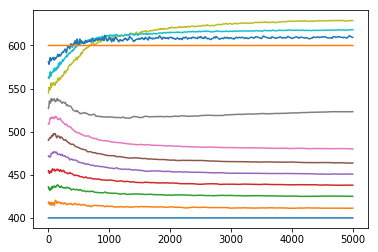

In [7]:
params = np.array(a.params)
pp.plot(params[:, :, 0]);

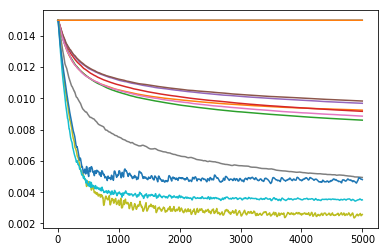

In [8]:
pp.plot(params[:, :, 1])
#pp.ylim(0, 0.004);

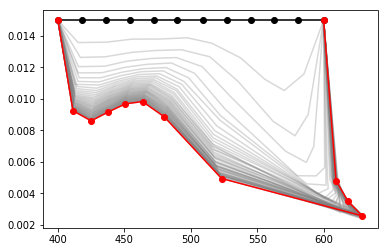

In [9]:
q = np.transpose(params, (1, 2, 0))
pp.plot(q[:, 0, ::100], q[:, 1, ::100], color='grey', alpha=0.3)
pp.plot(q[:, 0, 0], q[:, 1, 0], color='black', marker='o')
pp.plot(q[:, 0, -1], q[:, 1, -1], color='red', marker='o');

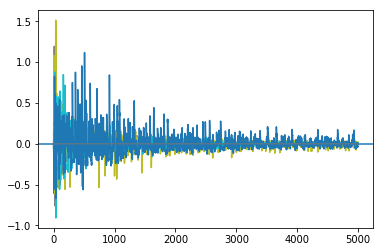

In [10]:
derivs = np.array(m.derivs)
pp.plot(derivs[:, :, 0])
pp.axhline(0);

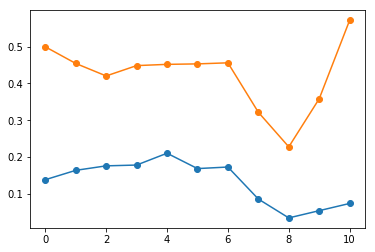

In [11]:
for i in range(n_steps):
    r.update()

acc2 = r.acceptance.copy()
a2 = np.product(acc2)
pp.plot(acc1, marker='o')
pp.plot(acc2, marker='o')
#pp.ylim(0, 1)

In [12]:
print a1, a2, a2 / a1

5.21268063532e-11 5.95248300584e-05 1141923.59407


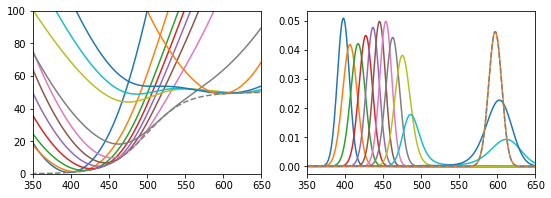

In [15]:
pp.figure(figsize=(9,3))

xs = np.array(range(1000))
y1 = logistic_energy(xs)
for i in range(n_cond):
    pp.subplot(1, 2, 1)
    parms = params[-1, i, :]
    y2 = umbrella_bias(xs, parms)[:, 0]
    y = y1 + y2
    pp.plot(xs, y)
    
    pp.subplot(1, 2, 2)
    p = np.exp(-y)
    p /= np.sum(p)
    pp.plot(xs, p)

pp.subplot(1, 2, 1)
pp.plot(xs, y1, color='grey', linestyle='--')
pp.ylim(0, 100)
pp.xlim(350, 650);

pp.subplot(1, 2, 2)
pp.plot(xs, p, color='grey', linestyle='--')
pp.xlim(350, 650);
